## **Pairs Trading using Kalman Filters**

**Rationale**
1. Moving Averages have a fixed window length and are thus, not dynamic and very prone to overfitting. Thus, by introducing Kalman Filters, we hope to address these problems in this notebook.

**Limitations of This Notebook**
1. Operates at 1 hour intervals due to Yahoo Finance limitations.
- If it is a viable strategy, use API to convert to shorter time frames, such as 5 or 15 min intervals.

<br>

## **Kalman Filter**

**Understanding Kalman Filter:**

The Kalman Filter is a mathematical algorithm that uses noisy observations from a time series or dynamic system to estimate its parameters (or state). These estimates are subsequently used to predict future observations, which in turn allow for continual updates to the parameters, enhancing accuracy over time.


**How Kalman Filter Differs from Moving Averages:**

While both the Kalman Filter and Moving Averages are techniques for data smoothing, the Kalman Filter does not rely on a predefined window, unlike the Moving Average. This characteristic not only minimizes the risk of overfitting but also enables the model to adapt more effectively to changes in trends and data patterns.


**Steps of Kalman Filter:**

1. Initialization of Observation Matrix, Transition Covariance Matrix, and Kalman Filter.
- Observation Matrix -> Initializes the observation matrix which includes all the observed measurements log(S1). It determines the y_pred (or log(S2) in our case) given the predicted next state.
- Transition Covariance -> Initializes the transition covariance matrix which controls the uncertainty in the state transition. It tells us how the system transitions from one state to another.
- Kalman Filter -> Initializes the kalman filter which includes initial estimates of the state and associated uncertainties.
2. Prediction -> Predict the next state based on current state estimate using the transition covariance matrix.

3. Update
- Compute Kalman Gain
- Update state estimate with the new measurement and also, the covariance matrix to reflect the updated state.

4. Reiterate -> Repeat Steps (2-3) for each new measurement.



**Gather Historical Data for all the stocks
 of interest**

In [1]:
import pandas as pd
import yfinance as yf
import statsmodels
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from statsmodels.tsa.stattools import coint
from pykalman import KalmanFilter

In [2]:
def get_historical_data(tickers):
    data = pd.DataFrame()
    names = list()
    for i in tickers:
        stock_data = yf.download(
            i,
            start=datetime(2024, 1, 1),
            end=datetime(2024, 10, 1),
            interval='1h',
            prepost=True
        ).iloc[:, 4]  # 'Adj Close' column (index 4)

        data = pd.concat([data, pd.DataFrame(stock_data)], axis=1)
        names.append(i)

    data.columns = names
    return data


In [3]:
tickers = ["QQQ", "NVDA", "AVGO", "META", "MSFT", "NFLX"]
df = get_historical_data(tickers)
df.tail(10)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,QQQ,NVDA,AVGO,META,MSFT,NFLX
Datetime,,,,,,
2024-09-30 10:30:00-04:00,486.890015,120.973801,172.845001,573.349976,427.921997,706.839905
2024-09-30 11:30:00-04:00,487.149994,120.714996,172.089996,573.679993,428.649902,707.000000
2024-09-30 12:30:00-04:00,485.720001,120.100700,171.190002,570.594971,427.459991,707.150513
2024-09-30 13:30:00-04:00,483.785004,119.470001,170.240005,567.690002,425.920013,703.820007
2024-09-30 14:30:00-04:00,485.199188,120.084999,171.070007,569.400024,427.204987,707.200012
2024-09-30 15:30:00-04:00,488.049988,121.489998,172.460007,572.359985,430.339996,709.270020
2024-09-30 16:00:00-04:00,487.150000,121.200000,172.210000,572.050000,428.160000,709.435000
2024-09-30 17:00:00-04:00,487.400000,121.060000,172.145000,572.030000,428.440000,708.685000
2024-09-30 18:00:00-04:00,487.180000,121.080000,172.070000,572.330000,428.335000,708.605000


**Test for Cointegration**

In [4]:
def find_cointegrated_pairs(df, tickers, threshold = 0.05):
  coint_matrix = pd.DataFrame(index=tickers, columns=tickers)
  pairs = []
  for i in range(len(tickers)):
      for j in range(len(tickers)):
          if i != j:
              stock1_data = df[tickers[i]].dropna()
              stock2_data = df[tickers[j]].dropna()

              # Align the data based on their indices
              aligned_data = pd.concat([stock1_data, stock2_data], axis=1, join='inner')
              aligned_data.columns = [tickers[i], tickers[j]]

              # Check if there's enough data after aligning
              if len(aligned_data) > 1:
                  score, p_value, _ = coint(aligned_data[tickers[i]], aligned_data[tickers[j]])
                  coint_matrix.iloc[i, j] = p_value  # Store the p-value in the matrix
                  if p_value < threshold:
                      pairs.append((tickers[i], tickers[j]))
              else:
                  coint_matrix.iloc[i, j] = np.nan  # Not enough data for cointegration test
          else:
              coint_matrix.iloc[i, j] = np.nan  # Diagonal elements are NaN

  return coint_matrix, pairs

Pairs:[('QQQ', 'AVGO'), ('AVGO', 'QQQ'), ('AVGO', 'NFLX'), ('META', 'NFLX'), ('NFLX', 'AVGO')]


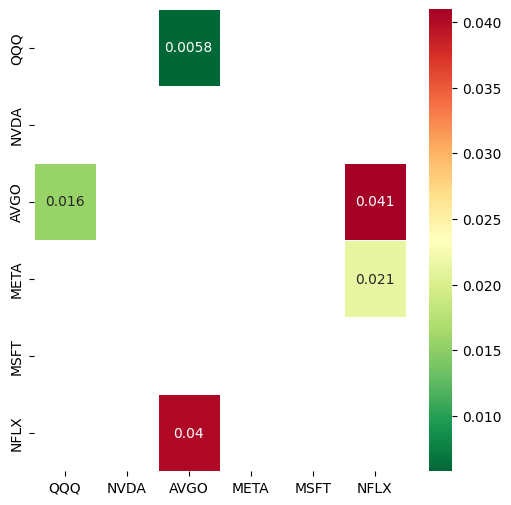

In [5]:
coint_matrix, pairs = find_cointegrated_pairs(df, tickers)

print(f"Pairs:{pairs}")

coint_long = coint_matrix.reset_index().melt(id_vars='index', var_name='Stock2', value_name='P-Value')
coint_long.rename(columns={'index': 'Stock1'}, inplace=True)

# Remove any rows with NaN P-values (like diagonal elements or where there's insufficient data)
coint_long.dropna(subset=['P-Value'], inplace=True)

# Create a heatmap using Seaborn
plt.figure(figsize=(6, 6))
heatmap_data = coint_matrix.astype(float)  # Ensure values are float for proper heatmap scaling

# Generate the heatmap
sns.heatmap(heatmap_data, annot=True, cmap='RdYlGn_r', cbar=True, linewidths=0.5, mask = (heatmap_data >= 0.05))


# Show the plot
plt.show()

Do some visual inspection on whether the pairs of stocks look cointegrated and correlated

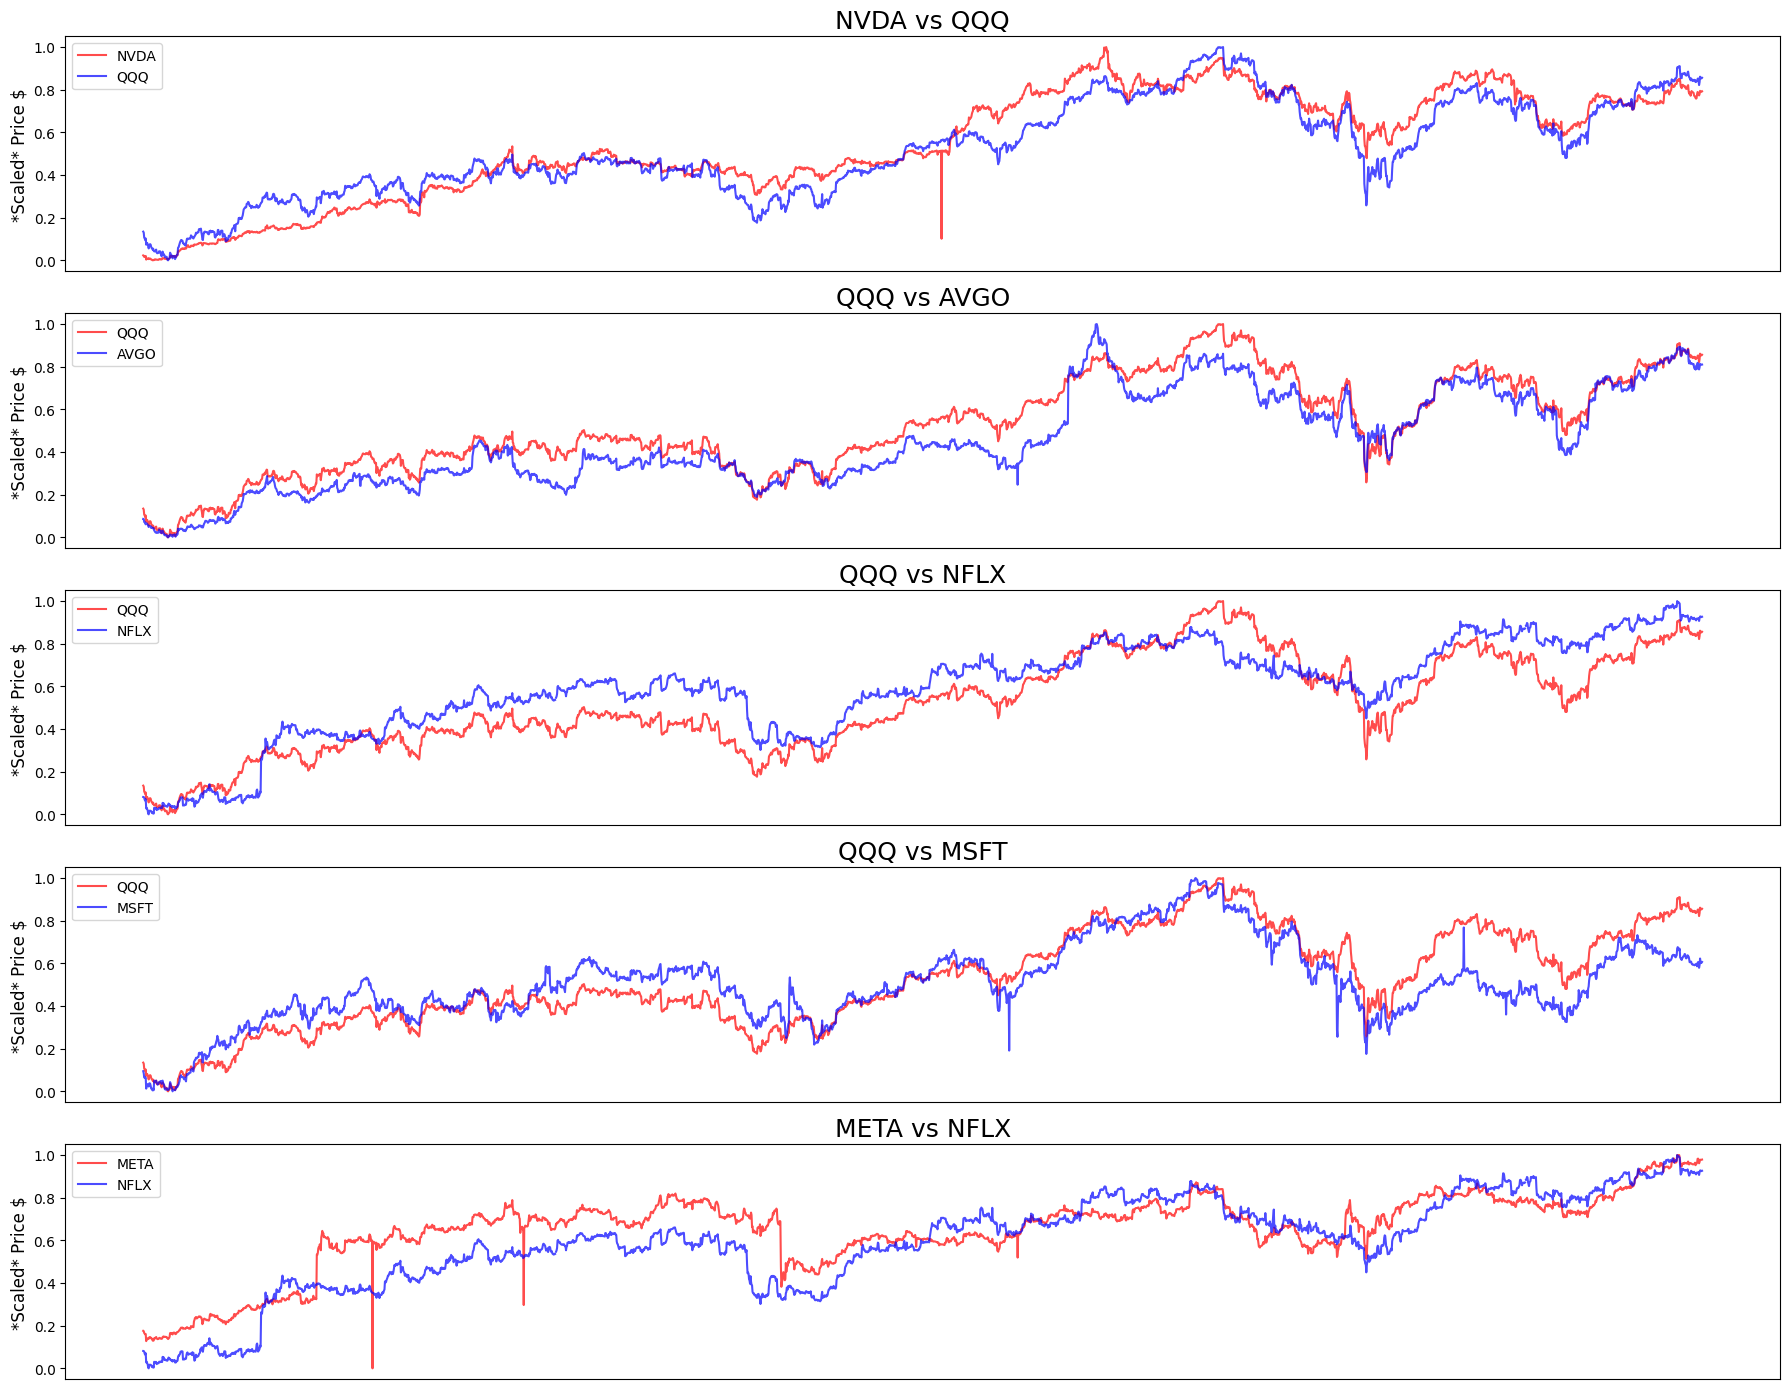

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Look for pairs that are very similar in movement and especially so, towards the end

# KEY ONES ARE QQQ -> NFLX or MSFT AND META -> NFLX

ticker_pairs = [("NVDA", "QQQ"), ("QQQ", "AVGO"), ("QQQ", "NFLX"), ("QQQ", "MSFT"), ("META", "NFLX")]

fig, axs = plt.subplots(len(ticker_pairs), 1, figsize=(18, 14))
scaler = MinMaxScaler()

for i, (ticker1, ticker2) in enumerate(ticker_pairs):
    # Scale the price data for each pair using MIN MAX
    scaled_data1 = scaler.fit_transform(
        df[ticker1].values.reshape(-1, 1))
    scaled_data2 = scaler.fit_transform(
        df[ticker2].values.reshape(-1, 1))

    axs[i].plot(scaled_data1, label=f'{ticker1}', color='red', alpha=0.7)
    axs[i].plot(scaled_data2, label=f'{ticker2}', color='blue', alpha=0.7)

    axs[i].set_ylabel('*Scaled* Price $', fontsize=12)
    axs[i].set_title(f'{ticker1} vs {ticker2}', fontsize=18)
    axs[i].legend()
    axs[i].set_xticks([])

plt.tight_layout()
plt.show()

**Find Correlated Pairs and select Stock Pair for Analysis**

<Axes: >

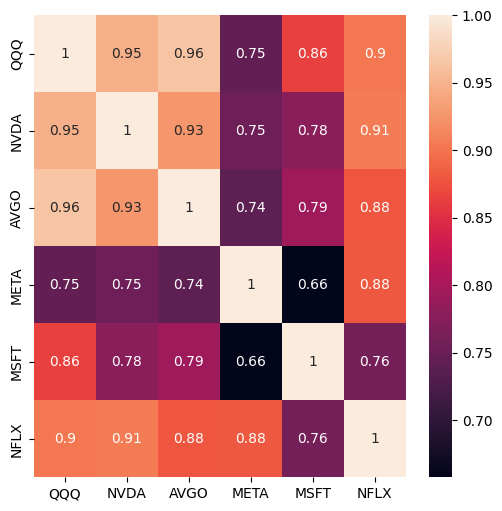

In [7]:
import seaborn as sn
from matplotlib.pyplot import figure

corr_matrix = df.corr()

figure(figsize=(6, 6))
sn.heatmap(corr_matrix, annot = True)

In [8]:
s1_name = 'AVGO'
s2_name = 'QQQ'
S1 = df[s1_name]
S2 = df[s2_name]

train = int(len(df[s1_name]) * 0.85)
test = len(df[s1_name]) - train

S1_train = df[s1_name][:train]
S2_train = df[s2_name][:train]

aligned_data = pd.concat([S1_train, S2_train], axis=1).dropna()

Now that we have selected two stocks, S1 and S2, that are cointegrated in their price movements and are also correlated, then we should expect any divergence in the spread to be temporary and mean-reverting.

We will now calculate the spread between the 2 stocks.

In [9]:
log_S1 = np.log(aligned_data[s1_name])
log_S2 = np.log(aligned_data[s2_name])


log_S1_with_const = sm.add_constant(log_S1)
results = sm.OLS(log_S2, log_S1_with_const).fit()

print(results.summary())

print(results.params)

a, b = results.params

                            OLS Regression Results                            
Dep. Variable:                    QQQ   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 3.428e+04
Date:                Tue, 22 Oct 2024   Prob (F-statistic):               0.00
Time:                        14:22:10   Log-Likelihood:                 7521.0
No. Observations:                2658   AIC:                        -1.504e+04
Df Residuals:                    2656   BIC:                        -1.503e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0997      0.011    378.988      0.0

In [10]:
log_spread = log_S2 - b*(log_S1)

log_fitted = a + b * log_S1

/var/folders/14/7ybs8ld16j96lm7k4q84hjbm0000gn/T/ipykernel_50072/4030106370.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels([str(p.date()) for p in log_S1[::len(log_S1)//9].index])


Text(0, 0.5, 'Log Price S2')

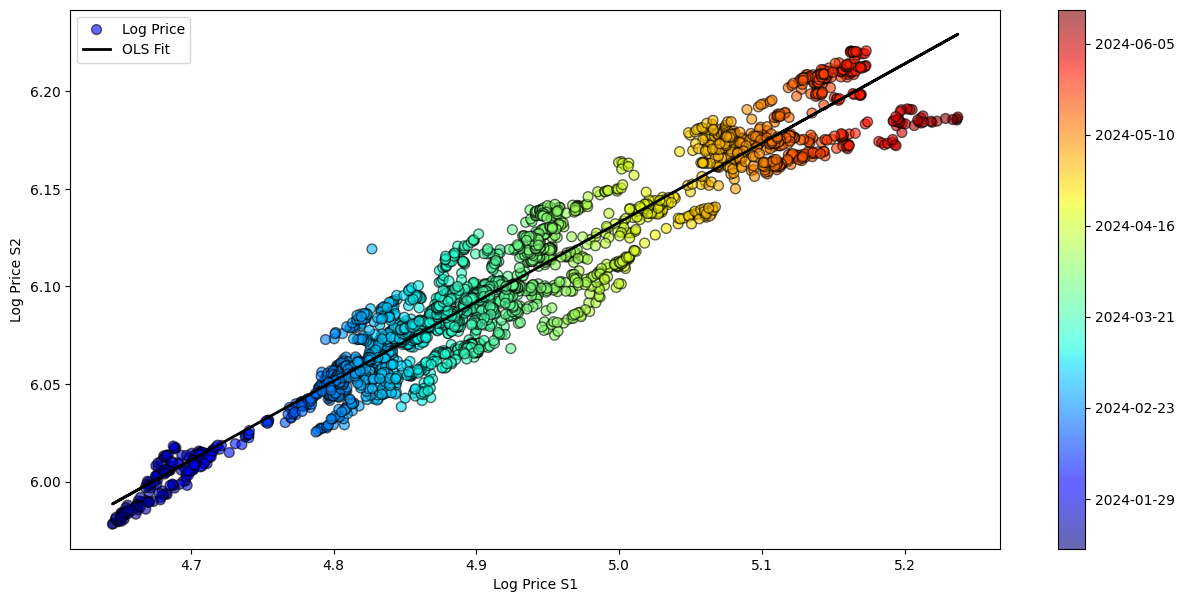

In [11]:
plt.figure(figsize =(15,7))

cm = plt.get_cmap('jet')
sc = plt.scatter(log_S1.values, log_S2.values, s=50, c=log_S1.values, cmap=cm, marker='o',
                 alpha=0.6, label='Log Price', edgecolor='k')
plt.plot(log_S1.values, log_fitted, '-',c='black',linewidth=2, label='OLS Fit')
plt.legend()
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in log_S1[::len(log_S1)//9].index])
plt.xlabel('Log Price S1')
plt.ylabel('Log Price S2')

Visualize the Log Spread between S1 and S2

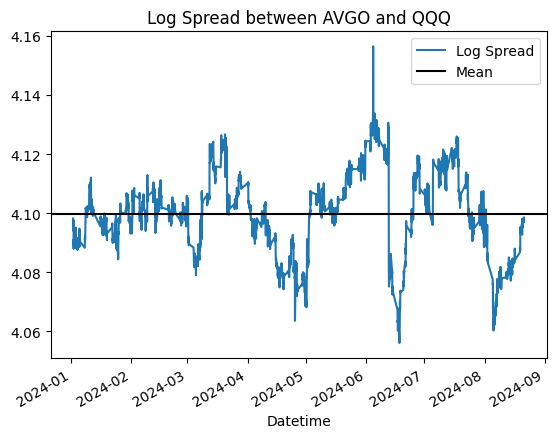

In [12]:
log_spread.plot()
plt.axhline(log_spread.mean(), color='black')
plt.legend(['Log Spread', 'Mean'])
plt.title(f'Log Spread between {s1_name} and {s2_name}')

plt.show()

### **Test for Stationarity on the Log Spread**

In [13]:
adf = sm.tsa.stattools.adfuller(log_spread, maxlag=1)
print('ADF test statistic: %.02f' % adf[0])
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))
print('p-value: %.03f' % adf[1])

ADF test statistic: -3.61
	1%: -3.433
	5%: -2.863
	10%: -2.567
p-value: 0.006


-- Test Results --

ADF test statistic < 0: The more negative the statistic is, the more likely we are to reject the null hypothesis of a unit root.

p-value - Indicates the probability of observing the test statistic under the null hypothesis. With p-value < 0.05, there is strong evidence against the null hypothesis. Therefore, we reject it and this gives us very strong evidence that the time series is stationary.

### **Applying the Kalman Filter**

Step 1: Initialize Observation Matrix, Transition Covariance and Kalman Filter

In [14]:
obs_mat = sm.add_constant(log_S1.values, prepend=False)[:, np.newaxis]
trans_cov = 1e-5 / (1 - 1e-5) * np.eye(2)

In [15]:
kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, 
                  initial_state_mean=[0,0],
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=2,
                  transition_covariance=trans_cov)

Step 2-4: Predict, Update and Reiterate.

The Kalman filter processes each observation and updates the state estimates based on the new measurements by applying Kalman Gain.

In [16]:
state_means, state_covs = kf.filter(log_S2.values)

Text(0, 0.5, 'intercept')

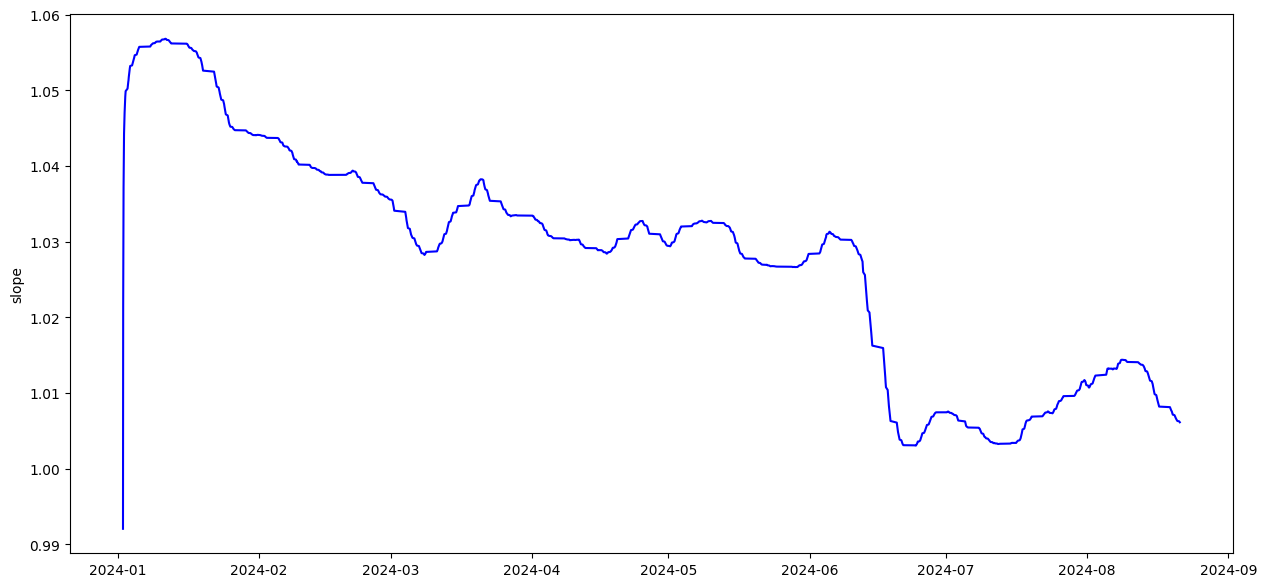

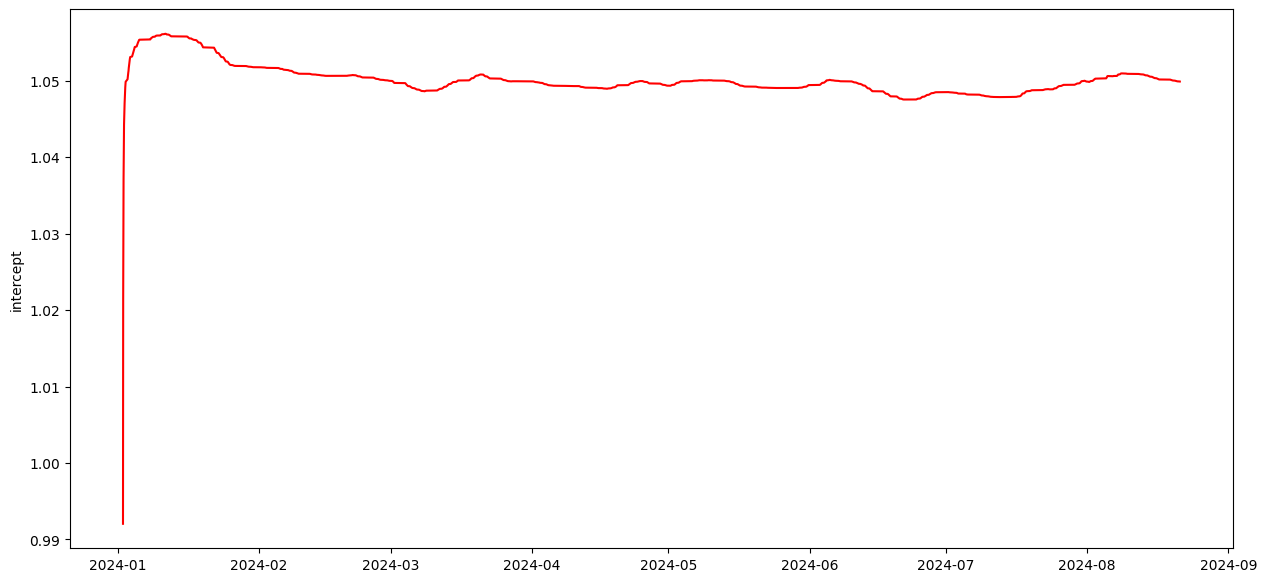

In [17]:
beta=state_means[:, 0] 
alpha=state_means[:, 1]
plt.figure(figsize =(15,7))
plt.plot(log_S2.index, beta, c='b')
plt.ylabel('slope')
plt.figure(figsize =(15,7))
plt.plot(log_S2.index,alpha,c='r')
plt.ylabel('intercept')

/var/folders/14/7ybs8ld16j96lm7k4q84hjbm0000gn/T/ipykernel_50072/4189766688.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels([str(p.date()) for p in log_S1[::len(log_S1)//7].index])


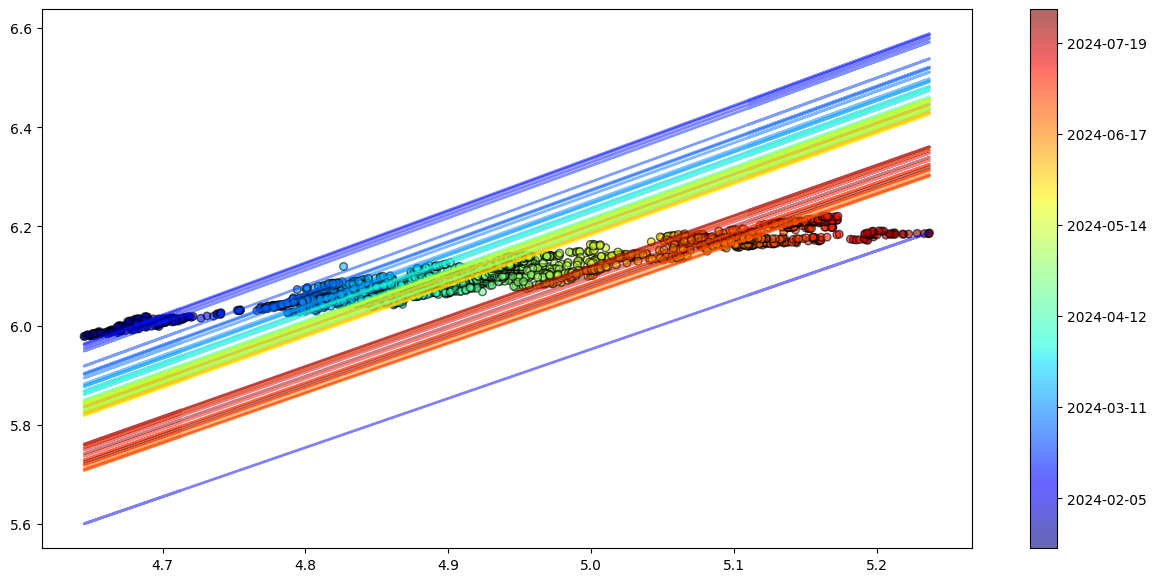

In [18]:
plt.figure(figsize =(15,7))
cm = plt.get_cmap('jet')
sc = plt.scatter(log_S1.values, log_S2.values, s=30, c=list(log_S1.values), cmap=cm, marker='o',
                 alpha=0.6,label='Price',edgecolor='k')
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in log_S1[::len(log_S1)//7].index])

# add regression lines
step = 50# pick beta and alpha every 100 period
colors_l = np.linspace(0.1, 1, len(state_means[::step]))
counter = 0
for i, b in enumerate(state_means[::step]):
    counter += 1
    plt.plot(log_S1.values, b[0] * log_S1.values + b[1], alpha=0.5, lw=2, c=cm(colors_l[i]))

### **Calculate Z-Spread**
Given the rolling beta and alpha, we can then estimate the z_score for the spread.

In [19]:
y_pred = beta * log_S1.values + alpha

log_spread = log_S2.values - y_pred

mean_spread = np.mean(log_spread)
std_spread = np.std(log_spread)
z_score = (log_spread - mean_spread) / std_spread

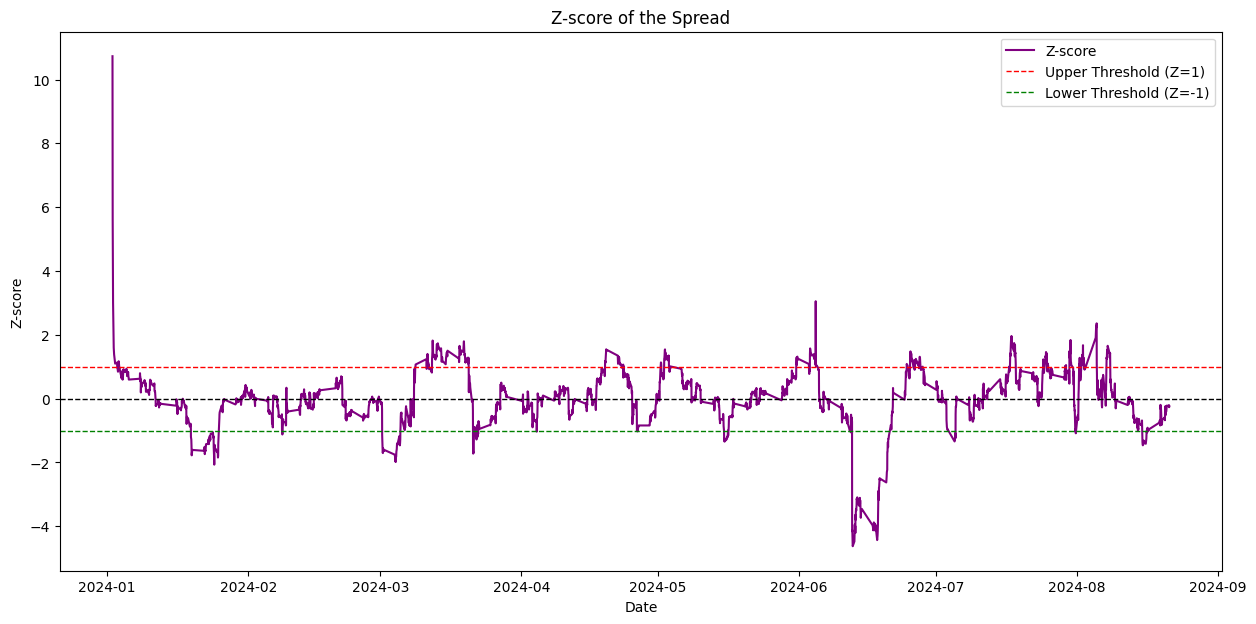

In [20]:
plt.figure(figsize=(15, 7))
plt.plot(log_S2.index, z_score, label='Z-score', color='purple')
plt.axhline(0, color='black', lw=1, ls='--')
plt.axhline(1, color='red', lw=1, ls='--', label='Upper Threshold (Z=1)')
plt.axhline(-1, color='green', lw=1, ls='--', label='Lower Threshold (Z=-1)')
plt.title('Z-score of the Spread')
plt.xlabel('Date')
plt.ylabel('Z-score')
plt.legend()
plt.show()

### **Further Works**

Now that we have obtained the z-scores, we can then obtain our entry and exit points for our strategy. 

One strategy that we can implement would be to long S1 and short S2 when z-scores passes the upper threshold, and short S1 and long S2 when z-scores passes the lower threshold.

An alternative strategy would be to use the Kalman spread directly to determine our entry and exit points.